<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score


Загружаем данные

In [2]:
data = pd.read_csv('Churn.csv')

In [3]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.shape

(10000, 14)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Признаки** 

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента 
- Surname — фамилия 
- CreditScore — кредитный рейтинг 
- Geography — страна проживания 
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

В наших данных есть один столбец с пропусками

In [6]:
data.duplicated().sum()

0

In [7]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


In [9]:
data['Tenure'] = data['Tenure'].fillna(0)

In [10]:
#data.dropna(subset=['Tenure'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [11]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

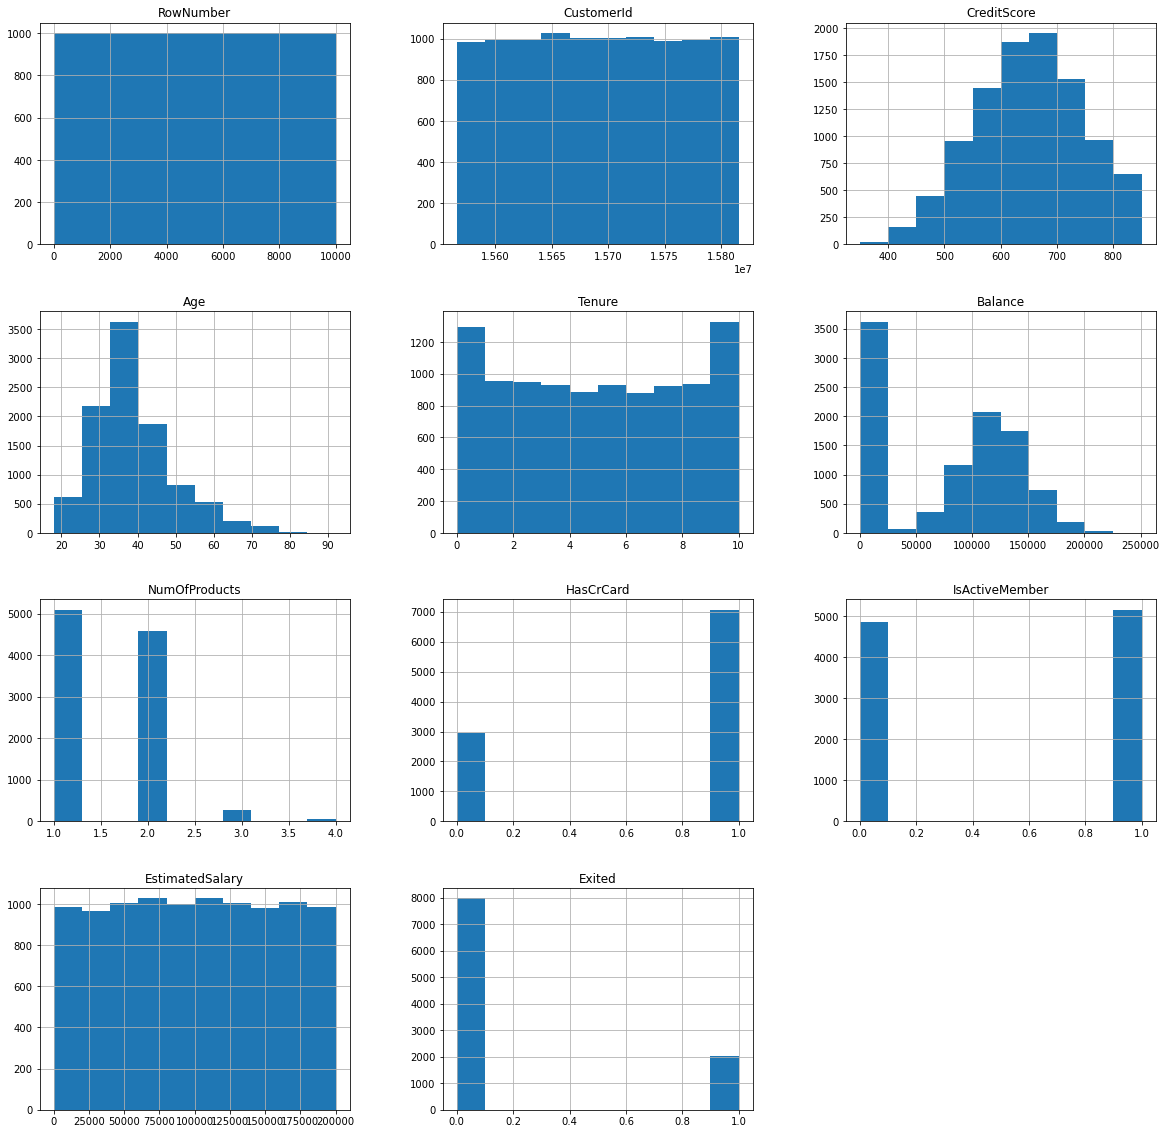

In [57]:
data.hist(figsize=(20, 20))
plt.show()

## Исследование задачи

Удалим столбцы не представляющие ценность для машинного обучения.

In [13]:
df_drop = ['RowNumber', 'CustomerId', 'Surname']
df = data.drop(df_drop, axis = 1)

In [14]:
df.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Избавляемся от дамми-ловушек.

In [16]:
df = pd.get_dummies(df, drop_first=True)

In [17]:
df.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [18]:
df.shape

(10000, 12)

In [19]:
target = df['Exited']
features = df.drop(['Exited'], axis=1)

Так как у нас только исходный датасет, то данные мы делим на три выборки: обучающую - 60%, валидационную - 20% и тестовую - 20%. 

In [20]:
state = np.random.RandomState(12345)

In [21]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=state, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=state, stratify=target_valid)

In [22]:
display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)

(6000, 11)

(2000, 11)

(2000, 11)

Масштабируем численные признаки.

In [23]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()

In [24]:
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head(5)

C:\Users\Marina\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.040434,0.953312,0.467449,0.774657,1,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-1.461501,1.910540,1,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.110432,0.481608,2,0,1,1.422836,0,0,1
660,-0.184996,0.190726,-1.461501,0.088439,1,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.140009,0.879129,1,1,0,0.113236,0,0,0


Обучение моделий

**Дерево решений**

In [25]:
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 50):
    model_tree = DecisionTreeClassifier(random_state=state, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predicted_valid = model_tree.predict(features_valid)
    accuracy_reg = model_tree.score(features_valid, target_valid) 
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_result_tree:
        best_result_tree = f1
        best_depth_tree = depth

print("Глубина дерева:", best_depth_tree)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f1)
print("accuracy:", accuracy_reg)

Глубина дерева: 7
Полнота: 0.5085995085995086
Точность: 0.4859154929577465
F-1: 0.49699879951980797
accuracy: 0.7905


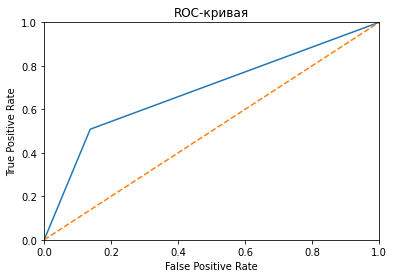

In [26]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [27]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1)

AUC-ROC: 0.6855615245445753
F-1: 0.49699879951980797


**Случайный лес**

In [28]:
%%time
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0
for est in range(30, 40):
    for depth in range (10, 15):
        model_forest = RandomForestClassifier(random_state=state, n_estimators=est, max_depth=depth) 
        model_forest.fit(features_train, target_train) 
        predicted_valid = model_forest.predict(features_valid) 
        accuracy_reg = model_forest.score(features_valid, target_valid) 
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_result_tree:
            best_result_forest = f1
            best_est_forest = est
            best_depth_forest = depth

print("Количество деревьев:", best_est_forest, "Максимальная глубина:", best_depth_forest)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f1)
print("accuracy:", accuracy_reg)

Количество деревьев: 37 Максимальная глубина: 12
Полнота: 0.44717444717444715
Точность: 0.7193675889328063
F-1: 0.5515151515151515
accuracy: 0.852
Wall time: 9.8 s


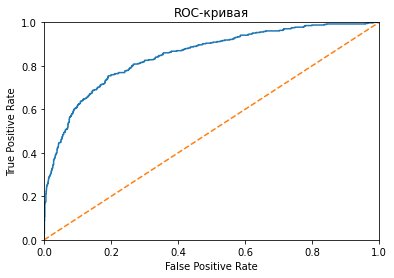

In [29]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [30]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1)

AUC-ROC: 0.8484339501288654
F-1: 0.5515151515151515


**Логистическая регрессия**

In [31]:
model_reg = LogisticRegression(random_state=12345, solver='liblinear') 
model_reg.fit(features_train, target_train) 
predicted_valid = model_reg.predict(features_valid)
accuracy_reg = model_reg.score(features_valid, target_valid) 

print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f1_score(target_valid, predicted_valid))
print("accuracy:", accuracy_reg)

Полнота: 0.2113022113022113
Точность: 0.6277372262773723
F-1: 0.31617647058823534
accuracy: 0.814


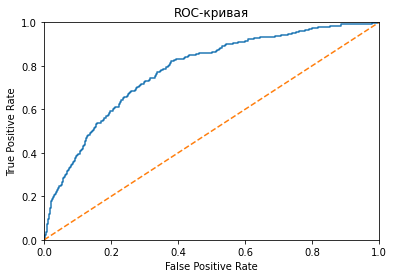

In [32]:
probabilities_valid = model_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [33]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1_score(target_valid, predicted_valid))

AUC-ROC: 0.7783577105611005
F-1: 0.31617647058823534


In [34]:
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

<AxesSubplot:ylabel='Frequency'>

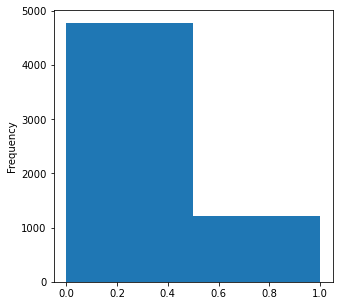

In [35]:
target_train.plot(kind='hist', bins=2, figsize=(5,5))


Были исследованы три модели. 
- «Дерево решений» лучший результат показало при глубине дерева = 7. F-1 = 0.49699879951980797, accuracy = 0.7905 
- «Случайный лес» лучший результат показал при количестве деревьев = 33 и глубине = 13. F-1 = 0.541033434650456, accuracy = 0.849 
- «Логистическая регрессия» F-1 = 0.31617647058823534, accuracy = 0.814

Лучший результат показал "Случайный лес". Но в наших данных есть дисбаланс. Из всех данных приблизительно 80% отрицательных ответов.


## Борьба с дисбалансом

Придадим объектам редкого класса больший вес.

**Дерево решений**

In [36]:
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(class_weight='balanced', random_state=state, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predicted_valid = model_tree.predict(features_valid)
    accuracy_reg = model_tree.score(features_valid, target_valid) 
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_result_tree:
        best_result_tree = f1
        best_depth_tree = depth

print("Глубина дерева:", best_depth_tree)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f1)
print("accuracy:", accuracy_reg)

Глубина дерева: 7
Полнота: 0.6535626535626535
Точность: 0.4353518821603928
F-1: 0.5225933202357563
accuracy: 0.757


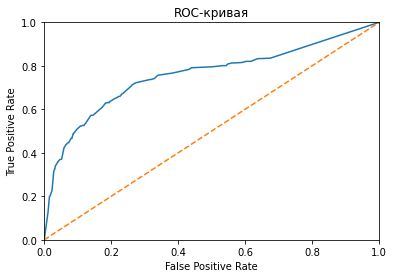

In [37]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [38]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1)

AUC-ROC: 0.7568323331035196
F-1: 0.5225933202357563


**Случайный лес**

In [39]:
%%time
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0
for est in range(20, 25):
    for depth in range (10, 15):
        model_forest = RandomForestClassifier(class_weight='balanced', random_state=state, n_estimators=est, max_depth=depth) 
        model_forest.fit(features_train, target_train) 
        predicted_valid = model_forest.predict(features_valid) 
        accuracy_reg = model_forest.score(features_valid, target_valid) 
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_result_tree:
            best_result_forest = f1
            best_est_forest = est
            best_depth_forest = depth

print("Количество деревьев:", best_est_forest, "Максимальная глубина:", best_depth_forest)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f1)
print("accuracy:", accuracy_reg)

Количество деревьев: 24 Максимальная глубина: 11
Полнота: 0.44963144963144963
Точность: 0.6535714285714286
F-1: 0.5327510917030568
accuracy: 0.8395
Wall time: 3.5 s


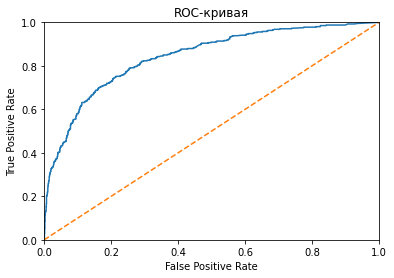

In [40]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [41]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1)

AUC-ROC: 0.8423222914748338
F-1: 0.5327510917030568


**Логистическая регрессия**

In [42]:
model_reg = LogisticRegression(random_state=state, solver='liblinear', class_weight='balanced') 
model_reg.fit(features_train, target_train) 
predicted_valid = model_reg.predict(features_valid)

print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f1_score(target_valid, predicted_valid))
accuracy_reg = model_reg.score(features_valid, target_valid) 
print("accuracy:", accuracy_reg)

Полнота: 0.7125307125307125
Точность: 0.3983516483516483
F-1: 0.5110132158590308
accuracy: 0.7225


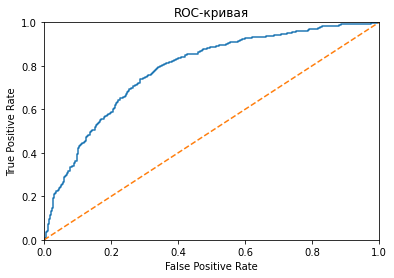

In [43]:
probabilities_valid = model_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [44]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1_score(target_valid, predicted_valid))

AUC-ROC: 0.7837560210441565
F-1: 0.5110132158590308


При придании объектам редкого класса большего веса, некоторые модели показали получше результаты. 

Воспользуемся увелечением выборки, чтоб объекты редкого класса не были такими редкими в данных.

In [45]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=state)
    
    return features_upsampled,target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [46]:
target_upsampled.value_counts(normalize = 1)

1    0.50569
0    0.49431
Name: Exited, dtype: float64

**Дерево решений**

In [47]:
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=state, max_depth=depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predicted_valid = model_tree.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_result_tree:
        best_result_tree = f1
        best_depth_tree = depth

print("Глубина дерева:", best_depth_tree)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f1)
accuracy_reg = model_tree.score(features_valid, target_valid) 
print("accuracy:", accuracy_reg)



Глубина дерева: 7
Полнота: 0.6535626535626535
Точность: 0.44333333333333336
F-1: 0.5283018867924528
accuracy: 0.7625


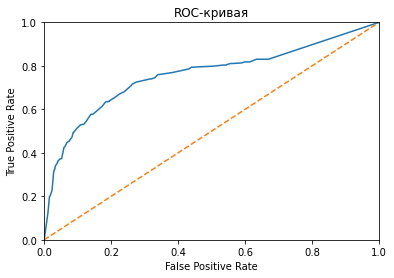

In [48]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [49]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1)

AUC-ROC: 0.7579235630083088
F-1: 0.5283018867924528


**Случайный лес**

In [50]:
%%time
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0
for est in range(105, 110):
    for depth in range (10, 15):
        model_forest = RandomForestClassifier(random_state=state, n_estimators=est, max_depth=depth) 
        model_forest.fit(features_upsampled, target_upsampled) 
        predicted_valid = model_forest.predict(features_valid) 
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_result_tree:
            best_result_forest = f1
            best_est_forest = est
            best_depth_forest = depth

print("Количество деревьев:", best_est_forest, "Максимальная глубина:", best_depth_forest)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f1)
accuracy_reg = model_forest.score(features_valid, target_valid) 
print("accuracy:", accuracy_reg)

Количество деревьев: 109 Максимальная глубина: 14
Полнота: 0.5651105651105651
Точность: 0.6133333333333333
F-1: 0.5882352941176471
accuracy: 0.839
Wall time: 20.4 s


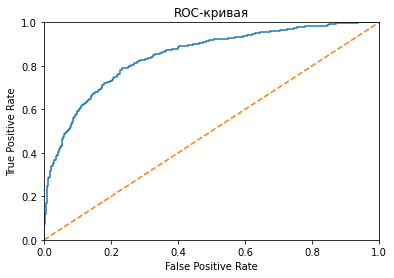

In [51]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [52]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1)

AUC-ROC: 0.8474514576209492
F-1: 0.5882352941176471


**Логистическая регрессия**

In [53]:
model_reg = LogisticRegression(random_state=state, solver='liblinear') 
model_reg.fit(features_upsampled, target_upsampled) 
predicted_valid = model_reg.predict(features_valid)
f_1 = f1_score(target_valid, predicted_valid)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("Точность:", precision_score(target_valid, predicted_valid))
print("F-1:", f_1)
accuracy_reg = model_reg.score(features_valid, target_valid) 
print("accuracy:", accuracy_reg)

Полнота: 0.7223587223587223
Точность: 0.393048128342246
F-1: 0.509090909090909
accuracy: 0.7165


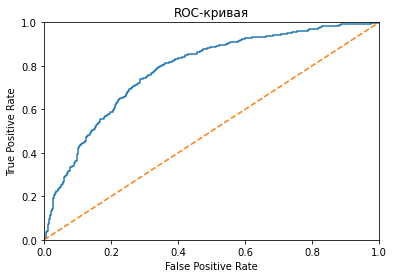

In [54]:
probabilities_valid = model_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [55]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)
print("F-1:", f1_score(target_valid, predicted_valid))

AUC-ROC: 0.7837930380303263
F-1: 0.509090909090909


После избавления от дисбаланса методом upsampling, были еще раз обучены три модели. Результаты моделей улучшились.
- «Дерево решений» лучший результат показало при глубине дерева = 7. F-1 = 0.5293532338308458, accuracy = 0.7635
- «Случайный лес» лучший результат показал при количестве деревьев = 109 и глубине = 14. F-1 = 0.5905006418485238, accuracy = 0.8405  
- «Логистическая регрессия» F-1 = 0.509090909090909, accuracy = 0.7165

Лучший результат показал "Случайный лес". На нем и будем тестировать.

## Тестирование модели

In [56]:
model_forest = RandomForestClassifier(class_weight='balanced', random_state=12345, n_estimators=109, max_depth=14) 
model_forest.fit(features_upsampled, target_upsampled) 
predicted_test = model_forest.predict(features_test)
f1 = f1_score(target_test, predicted_test)

print("Полнота:", recall_score(target_test, predicted_test))
print("Точность:", precision_score(target_test, predicted_test))
print("F-1:", f1)
accuracy_reg = model_forest.score(features_valid, target_valid) 
print("accuracy:", accuracy_reg)

Полнота: 0.6078431372549019
Точность: 0.6108374384236454
F-1: 0.6093366093366093
accuracy: 0.842


## Выводы

В рамках проекта были проведены исследования и выбрана лучшая модель для прогнозироватьния, уйдёт клиент из банка в ближайшее время или нет.
Для анализа были загруженны, проанализированы и скорректированы данные.
Были исследованы три модели. 
- «Дерево решений» лучший результат показало при глубине дерева = 7. F-1 = 0.49699879951980797, accuracy = 0.7905 
- «Случайный лес» лучший результат показал при количестве деревьев = 33 и глубине = 13. F-1 = 0.541033434650456, accuracy = 0.849 
- «Логистическая регрессия» F-1 = 0.31617647058823534, accuracy = 0.814

Лучший результат показал "Случайный лес". Но в наших данных был дисбаланс. Из всех данных приблизительно 80% отрицательных ответов.
После исбавления от дисбаланса методом upsampling, были еще раз обучены три модели. Результаты моделей улучшились.
- «Дерево решений» лучший результат показало при глубине дерева = 7. F-1 = 0.5293532338308458, accuracy = 0.7635
- «Случайный лес» лучший результат показал при количестве деревьев = 109 и глубине = 14. F-1 = 0.5905006418485238, accuracy = 0.8405  
- «Логистическая регрессия» F-1 = 0.509090909090909, accuracy = 0.7165

Лучший результат показал "Случайный лес". На нем и провели тестирование.

Выбранная модель на тестовых данных показала самые высокие результаты F-1 = 0.6093366093366093,
accuracy = 0.842.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*